In [56]:
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import datetime as now
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from matplotlib import style
style.use('ggplot')
%matplotlib notebook

from sklearn import svm, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

import os
os.chdir('/Users/pipegalera/Documents/GitHub/side_projects/finance')

### Import data

In [57]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020,12,1)

data = web.get_data_yahoo('NVDA', start, end)

### Creating a column with rolling average

In [58]:
data['Rolling Close'] = data['Adj Close'].rolling(window = 100, min_periods = 0).mean()

### Plot data

In [59]:
fig = px.line(data, x = data.index, y = 'Rolling Close', title = 'NVDA stocks')

fig.show()

<IPython.core.display.Javascript object>


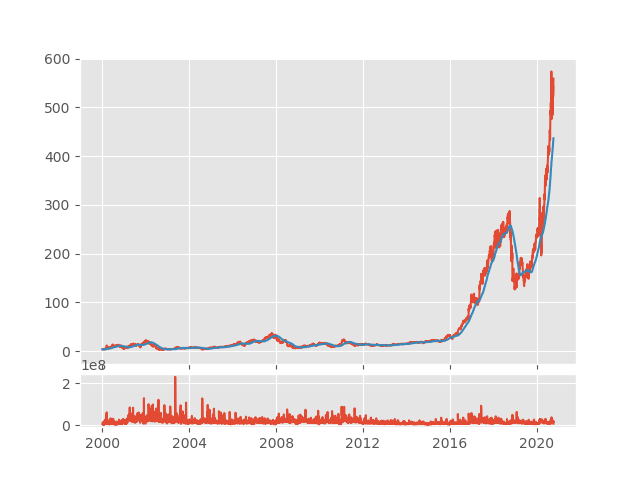

In [60]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 5, colspan = 1, sharex = ax1)

ax1.plot(data.index, data['Adj Close'])
ax1.plot(data.index, data['Rolling Close'])
ax2.plot(data.index, data['Volume'])

### Creating an 'OHLC' Resamplaing

We don't have to resample the volume data, but we should, since it would be too granular compared to our 10D pricing data. 

In [63]:
data_ohlc = data['Adj Close'].resample('10D').ohlc()
data_volume = data['Volume'].resample('10D').sum()

In [64]:
print(data_ohlc)

                  open        high         low       close
Date                                                      
2000-01-03    3.587727    3.587727    3.099145    3.099145
2000-01-13    3.228475    3.511086    3.228475    3.429657
2000-01-23    3.276375    3.276375    2.840484    2.907544
2000-02-02    2.988974    3.832018    2.917124    3.832018
2000-02-12    4.445141    5.163644    4.272700    5.163644
...                ...         ...         ...         ...
2020-08-25  509.847473  573.859985  504.978912  520.619995
2020-09-04  504.899994  508.600006  476.519989  486.579987
2020-09-14  514.890015  519.640015  484.950012  484.950012
2020-09-24  493.920013  544.580017  493.920013  522.489990
2020-10-04  545.700012  559.320007  545.700012  559.320007

[759 rows x 4 columns]


### Plot using matplotlib.finance 

First, we have to convert the dates (index) to a matplotlib dates format.

In [65]:
data_ohlc.reset_index(inplace = True)
data_ohlc['Date'] = data_ohlc['Date'].map(mdates.date2num)

In the first graph we use the candlestick, while in the second the volume

<IPython.core.display.Javascript object>


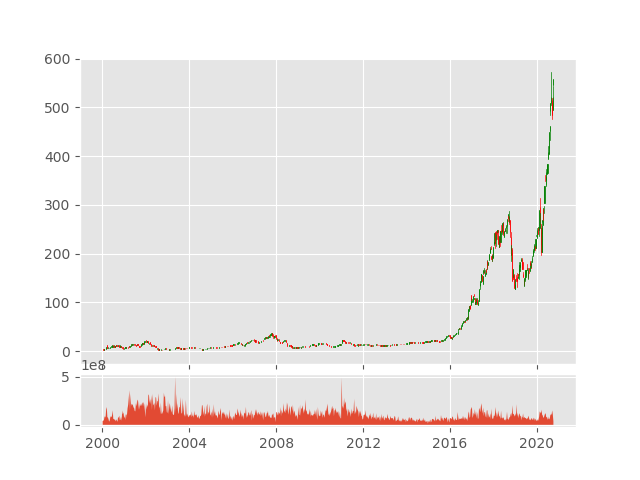

In [66]:
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 5, colspan = 1, sharex = ax1)

ax1.xaxis_date()
candlestick_ohlc(ax1, data_ohlc.values, width = 2, colorup = 'g', colordown='r')
ax2.fill_between(data_volume.index.map(mdates.date2num), data_volume.values, 0)
 

# Automating getting the S&P 500 list

In [67]:
import bs4 as bs
import pickle 
import requests

In [68]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('.', '-')
        ticker = ticker[:-1]
        tickers.append(ticker)
    
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
    
    return tickers

#save_sp500_tickers()

# Getting all company pricing data in the S&P 500

In [69]:
def get_data_from_yahoo(reload_sp500 = False):
    # Get the tickers from the previous function
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', "rb") as f:
            tickers = pickle.load(f)
            
    # If the file does not exist create it
    if not os.path.exists('raw_data/stocks_dfs'):
        os.makedirs('raw_data/stocks_dfs') 
        
    # Set the datetime you want to take the stocks
    start = dt.datetime(2000,1,1)
    end = dt.datetime.now()
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('raw_data/stocks_dfs/{}.csv'.format(ticker)):
            df = web.get_data_yahoo(ticker, start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            df.to_csv('raw_data/stocks_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

        
get_data_from_yahoo()

MMM
Already have MMM
ABT
Already have ABT
ABBV
Already have ABBV
ABMD
Already have ABMD
ACN
Already have ACN
ATVI
Already have ATVI
ADBE
Already have ADBE
AMD
Already have AMD
AAP
Already have AAP
AES
Already have AES
AFL
Already have AFL
A
Already have A
APD
Already have APD
AKAM
Already have AKAM
ALK
Already have ALK
ALB
Already have ALB
ARE
Already have ARE
ALXN
Already have ALXN
ALGN
Already have ALGN
ALLE
Already have ALLE
AGN
Already have AGN
ADS
Already have ADS
LNT
Already have LNT
ALL
Already have ALL
GOOGL
Already have GOOGL
GOOG
Already have GOOG
MO
Already have MO
AMZN
Already have AMZN
AMCR
Already have AMCR
AEE
Already have AEE
AAL
Already have AAL
AEP
Already have AEP
AXP
Already have AXP
AIG
Already have AIG
AMT
Already have AMT
AWK
Already have AWK
AMP
Already have AMP
ABC
Already have ABC
AME
Already have AME
AMGN
Already have AMGN
APH
Already have APH
ADI
Already have ADI
ANSS
Already have ANSS
ANTM
Already have ANTM
AON
Already have AON
AOS
Already have AOS
APA
Alre

# Combining S&P 500 into one DataFrame

In [70]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('raw_data/stocks_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        # We are only interested in the closing price, that we call like the company and we drop everything else.
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'Close', 'High', 'Low', 'Volume'], axis = 1, inplace = True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how = 'outer')
            
        if count % 10 == 0:
            print(count)

        main_df.to_csv('raw_data/sp500_joined_closes.csv')
        print(main_df.head())
    
#compile_data()

0
                  MMM
Date                 
2000-01-03  28.592686
2000-01-04  27.456560
2000-01-05  28.251841
2000-01-06  30.524109
2000-01-07  31.130033
                  MMM       ABT
Date                           
2000-01-03  28.592686  6.564564
2000-01-04  27.456560  6.377004
2000-01-05  28.251841  6.365284
2000-01-06  30.524109  6.588011
2000-01-07  31.130033  6.658342
                  MMM       ABT  ABBV
Date                                 
2000-01-03  28.592686  6.564564   NaN
2000-01-04  27.456560  6.377004   NaN
2000-01-05  28.251841  6.365284   NaN
2000-01-06  30.524109  6.588011   NaN
2000-01-07  31.130033  6.658342   NaN
                  MMM       ABT  ABBV      ABMD
Date                                           
2000-01-03  28.592686  6.564564   NaN  18.25000
2000-01-04  27.456560  6.377004   NaN  17.81250
2000-01-05  28.251841  6.365284   NaN  18.00000
2000-01-06  30.524109  6.588011   NaN  18.03125
2000-01-07  31.130033  6.658342   NaN  17.93750
                  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES       AFL          A        APD     AKAM  \
Date                                                                          
2000-01-03  15.500  NaN  28.296314  5.379488  44.777622  18.104057  321.250   
2000-01-04  14.625  NaN  27.174225  5.236737  41.357113  17.552309  300.000   
2000-01-05  15.000  NaN  27.466946  5.206684  38.791721  17.655748  283.500   
2000-01-06  16.000  NaN  27.686485  5.311871  37.314693  18.82821

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        APD     AKAM       ALK  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  18.104057  321.250  7.713035   
2000-01-04  14.625  NaN  27.174225  ...  17.552309  300.000  7.616623   
2000-01-05  15.000  NaN  27.466946  ...  17.655748  283.500  7.657942   
2000-01-06  16.000  NaN  27.686485  ...  18.828213  236.125  7.664831   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  ALGN  ALLE        AGN  ADS       LNT  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...   NaN   NaN  29.255426  NaN  5.336293   
2000-01-04  14.625  NaN  27.174225  ...   NaN   NaN  28.315071  NaN  5.336293   
2000-01-05  15.000  NaN  27.466946  ...   NaN   NaN  28.837484  NaN  5.597509   
2000-01-06  16.000  NaN  27.686485  ...   NaN   NaN  29

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  GOOGL  GOOG        MO     AMZN  AMCR  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...    NaN   NaN  1.819708  89.3750   NaN   
2000-01-04  14.625  NaN  27.174225  ...    NaN   NaN  1.834266  81.9375   NaN   
2000-01-05  15.000  NaN  27.466946  ...    NaN   NaN  1.824561  69.7500   NaN   
2000-01-06  16.000  NaN  27.686485  ...    NaN   NaN  1

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  AAL        AEP        AXP  \
Date                                ...                              
2000-01-03  15.500  NaN  28.296314  ...  NaN  12.473226  34.683704   
2000-01-04  14.625  NaN  27.174225  ...  NaN  12.622015  33.374104   
2000-01-05  15.000  NaN  27.466946  ...  NaN  13.093165  32.526413   
2000-01-06  16.000  NaN  27.686485  ...  NaN  13.167562  33.189102   
2000-01-07  16.250  NaN  28.223131  ... 

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  AMP       ABC       AME       AMGN  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  NaN  2.995721  1.857676  51.197449   
2000-01-04  14.625  NaN  27.174225  ...  NaN  2.791193  1.851566  47.282646   
2000-01-05  15.000  NaN  27.466946  ...  NaN  3.007750  1.869898  48.909573   
2000-01-06  16.000  NaN  27.686485  ...  NaN  3.236340  1.857676 

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        ADI      ANSS  ANTM        AON  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  30.618002  2.765625   NaN  27.607428   
2000-01-04  14.625  NaN  27.174225  ...  29.069048  2.687500   NaN  26.988020   
2000-01-05  15.000  NaN  27.466946  ...  29.493437  2.703125   NaN  27.784399   
2000-01-06  16.000  NaN  27.686485  ...  28.687130  2.7

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        AIV      AAPL       AMAT  APTV  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  13.803980  3.460857  24.100704   NaN   
2000-01-04  14.625  NaN  27.174225  ...  13.622343  3.169071  22.909958   NaN   
2000-01-05  15.000  NaN  27.466946  ...  13.758573  3.215448  22.052626   NaN   
2000-01-06  16.000  NaN  27.686485  ...  14.031017  2.9

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       AJG  AIZ          T       ATO  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  7.779252  NaN  17.282593  8.832526   
2000-01-04  14.625  NaN  27.174225  ...  7.427733  NaN  16.271378  8.612400   
2000-01-05  15.000  NaN  27.466946  ...  7.458300  NaN  16.524181  8.887558   
2000-01-06  16.000  NaN  27.686485  ...  7.444930  NaN  16.175280

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        ADP      AZO        AVB  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  26.878614  30.5625  15.067223   
2000-01-04  14.625  NaN  27.174225  ...  26.878614  30.4375  14.734252   
2000-01-05  15.000  NaN  27.466946  ...  26.620173  30.3125  14.872992   
2000-01-06  16.000  NaN  27.686485  ...  26.975552  29.0625  15.372456   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       BLL        BAC         BK  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  0.869111  11.966080  25.328106   
2000-01-04  14.625  NaN  27.174225  ...  0.840459  11.255836  24.600775   
2000-01-05  15.000  NaN  27.466946  ...  0.855467  11.379356  24.044584   
2000-01-06  16.000  NaN  27.686485  ...  0.869111  12.352086  24.643557   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...      BRK-B        BBY       BIIB  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  35.299999  18.150681  31.083334   
2000-01-04  14.625  NaN  27.174225  ...  34.080002  18.032827  28.979166   
2000-01-05  15.000  NaN  27.466946  ...  34.639999  17.914955  31.000000   
2000-01-06  16.000  NaN  27.686485  ...  36.080002  17.757807  32.375000   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...     BKNG       BWA        BXP  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  307.500  2.292869  15.232924   
2000-01-04  14.625  NaN  27.174225  ...  324.000  2.292869  14.984723   
2000-01-05  15.000  NaN  27.466946  ...  359.625  2.303982  15.108823   
2000-01-06  16.000  NaN  27.686485  ...  345.000  2.274348  15.388036   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  BR      BF-B      CHRW       COG  \
Date                                ...                                     
2000-01-03  15.500  NaN  28.296314  ... NaN  1.056217  6.855355  0.686059   
2000-01-04  14.625  NaN  27.174225  ... NaN  1.036743  6.625382  0.665796   
2000-01-05  15.000  NaN  27.466946  ... NaN  1.044762  6.537773  0.677375   
2000-01-06  16.000  NaN  27.686485  ... NaN  1.051635  6.570628  0.691849  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        COF  CPRI        CAH      KMX  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  36.135490   NaN  16.953266  1.12500   
2000-01-04  14.625  NaN  27.174225  ...  33.886169   NaN  16.759890  1.09375   
2000-01-05  15.000  NaN  27.466946  ...  33.103817   NaN  17.941675  1.06250   
2000-01-06  16.000  NaN  27.686485  ...  34.619633   NaN  18

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        CAT  CBOE  CBRE  CDW  CE  CNC  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  11.845388   NaN   NaN  NaN NaN  NaN   
2000-01-04  14.625  NaN  27.174225  ...  11.693136   NaN   NaN  NaN NaN  NaN   
2000-01-05  15.000  NaN  27.466946  ...  11.967190   NaN   NaN  NaN NaN  NaN   
2000-01-06  16.000  NaN  27.686485  ...  12.576205   NaN   N

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       CNP        CTL      CERN  CF  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  6.299262  16.101336  2.527873 NaN   
2000-01-04  14.625  NaN  27.174225  ...  6.370040  15.456391  2.481490 NaN   
2000-01-05  15.000  NaN  27.466946  ...  6.635459  15.567590  2.481490 NaN   
2000-01-06  16.000  NaN  27.686485  ...  6.670847  15.389672  2.466029

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        CVX  CMG        CB       CHD  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  17.419516  NaN  7.325750  2.032865   
2000-01-04  14.625  NaN  27.174225  ...  17.419516  NaN  7.269614  1.983997   
2000-01-05  15.000  NaN  27.466946  ...  17.731968  NaN  6.848598  1.983997   
2000-01-06  16.000  NaN  27.686485  ...  18.487068  NaN  7.213480

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       CINF       CTAS       CSCO  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  13.659487  27.019138  41.433525   
2000-01-04  14.625  NaN  27.174225  ...  13.645506  25.920277  39.109055   
2000-01-05  15.000  NaN  27.466946  ...  13.785316  26.211151  38.989223   
2000-01-06  16.000  NaN  27.686485  ...  13.869204  26.356592  38.342190   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       CTXS        CLX  CME        CMS  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  49.982899  28.628084  NaN  15.633224   
2000-01-04  14.625  NaN  27.174225  ...  47.520329  27.864162  NaN  15.831955   
2000-01-05  15.000  NaN  27.466946  ...  44.789551  28.591700  NaN  16.262531   
2000-01-06  16.000  NaN  27.686485  ...  40.961594  28.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...      CTSH         CL      CMCSA  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  1.930510  15.416033  12.436954   
2000-01-04  14.625  NaN  27.174225  ...  1.865154  15.013605  11.505847   
2000-01-05  15.000  NaN  27.466946  ...  1.968215  14.502837  11.206564   
2000-01-06  16.000  NaN  27.686485  ...  1.867668  14.471879  11.638860   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  CXO       COP         ED       STZ  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  NaN  6.827606  12.767960  5.836346   
2000-01-04  14.625  NaN  27.174225  ...  NaN  6.695764  12.933472  5.616660   
2000-01-05  15.000  NaN  27.466946  ...  NaN  6.573339  13.524576  5.807055   
2000-01-06  16.000  NaN  27.686485  ...  NaN  6.799354  13.548223

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        GLW  CTVA       COST  COTY  \
Date                                ...                                     
2000-01-03  15.500  NaN  28.296314  ...  31.095638   NaN  32.375179   NaN   
2000-01-04  14.625  NaN  27.174225  ...  28.080212   NaN  30.601828   NaN   
2000-01-05  15.000  NaN  27.466946  ...  27.442020   NaN  31.124743   NaN   
2000-01-06  16.000  NaN  27.686485  ...  26.803837   NaN  31.749947   NaN  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       CSX       CMI        CVS  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  3.501594  4.203157  13.832482   
2000-01-04  14.625  NaN  27.174225  ...  3.395484  4.086557  13.718168   
2000-01-05  15.000  NaN  27.466946  ...  3.466223  4.092109  14.472672   
2000-01-06  16.000  NaN  27.686485  ...  3.621849  4.236472  13.443807   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       DVA         DE  DAL      XRAY  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  2.291667  12.027299  NaN  6.954667   
2000-01-04  14.625  NaN  27.174225  ...  2.250000  12.009768  NaN  6.954667   
2000-01-05  15.000  NaN  27.466946  ...  2.062500  12.290285  NaN  7.074894   
2000-01-06  16.000  NaN  27.686485  ...  2.000000  12.921459  NaN

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  DLR  DFS  DISCA  DISCK       DISH  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  NaN  NaN    NaN    NaN  33.913342   
2000-01-04  14.625  NaN  27.174225  ...  NaN  NaN    NaN    NaN  32.666359   
2000-01-05  15.000  NaN  27.466946  ...  NaN  NaN    NaN    NaN  32.555019   
2000-01-06  16.000  NaN  27.686485  ...  NaN  NaN    NaN    NaN  29.28

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       DLTR         D        DOV  DOW  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  10.861111  5.982473  17.053835  NaN   
2000-01-04  14.625  NaN  27.174225  ...  10.847222  6.129583  16.738024  NaN   
2000-01-05  15.000  NaN  27.466946  ...  10.861111  6.296309  16.810896  NaN   
2000-01-06  16.000  NaN  27.686485  ...  11.055555  6.364962

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        DUK       DRE         DD  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  21.758743  6.057658  31.433344   
2000-01-04  14.625  NaN  27.174225  ...  22.096954  6.017806  30.574173   
2000-01-05  15.000  NaN  27.466946  ...  22.998890  6.037733  31.566656   
2000-01-06  16.000  NaN  27.686485  ...  23.618952  6.177219  32.455444   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       EMN       ETN      EBAY  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  7.776294  2.688206  7.287086   
2000-01-04  14.625  NaN  27.174225  ...  7.587906  2.596401  6.603519   
2000-01-05  15.000  NaN  27.466946  ...  7.964685  2.617585  7.045258   
2000-01-06  16.000  NaN  27.686485  ...  8.467057  2.671727  6.958200   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  EW         EA        EMR        ETR  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ... NaN  25.265625  15.816958  11.400367   
2000-01-04  14.625  NaN  27.174225  ... NaN  22.343750  15.628047  11.428587   
2000-01-05  15.000  NaN  27.466946  ... NaN  22.328125  15.920008  11.908303   
2000-01-06  16.000  NaN  27.686485  ... NaN  20.000000  16.3

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        EFX  EQIX       EQR        ESS  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  10.936976   NaN  7.001130  15.226315   
2000-01-04  14.625  NaN  27.174225  ...  10.570374   NaN  6.949269  15.054901   
2000-01-05  15.000  NaN  27.466946  ...  10.448171   NaN  7.094478  14.997775   
2000-01-06  16.000  NaN  27.686485  ...  10.325974   Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...         ES         RE       EXC  EXPE  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  10.837969  15.743755  7.960957   NaN   
2000-01-04  14.625  NaN  27.174225  ...  10.837969  15.698774  7.902205   NaN   
2000-01-05  15.000  NaN  27.466946  ...  10.903458  16.733370  8.284095   NaN   
2000-01-06  16.000  NaN  27.686485  ...  11.034426  17.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        XOM      FFIV  FB      FAST  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  21.818495  59.75000 NaN  1.851905   
2000-01-04  14.625  NaN  27.174225  ...  21.400583  58.96875 NaN  1.745536   
2000-01-05  15.000  NaN  27.466946  ...  22.567265  55.40625 NaN  1.819176   
2000-01-06  16.000  NaN  27.686485  ...  23.733942  51.06250 NaN  1.81

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  FIS       FITB        FE  FRC  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  NaN  27.507853  8.743098  NaN   
2000-01-04  14.625  NaN  27.174225  ...  NaN  26.351439  8.743098  NaN   
2000-01-05  15.000  NaN  27.466946  ...  NaN  25.957760  9.065085  NaN   
2000-01-06  16.000  NaN  27.686485  ...  NaN  26.868122  9.089853  NaN   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...      FLIR       FLS       FMC  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  1.854045  3.964988  4.771420   
2000-01-04  14.625  NaN  27.174225  ...  1.708765  3.889609  4.711777   
2000-01-05  15.000  NaN  27.466946  ...  1.798700  3.949913  4.798528   
2000-01-06  16.000  NaN  27.686485  ...  1.784864  3.964988  4.793107   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  FBHS  FOXA  FOX       BEN       FCX  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...   NaN   NaN  NaN  6.348482  5.760734   
2000-01-04  14.625  NaN  27.174225  ...   NaN   NaN  NaN  6.235785  5.437866   
2000-01-05  15.000  NaN  27.466946  ...   NaN   NaN  NaN  6.335961  5.641784   
2000-01-06  16.000  NaN  27.686485  ...   NaN   NaN  NaN  6.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  GRMN      IT         GD         GE  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...   NaN  16.625  16.108694  25.534224   
2000-01-04  14.625  NaN  27.174225  ...   NaN  15.375  16.785870  24.512873   
2000-01-05  15.000  NaN  27.466946  ...   NaN  14.750  17.935028  24.470304   
2000-01-06  16.000  NaN  27.686485  ...   NaN  14.750  17.996588 

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        GPC      GILD        GL  GPN  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  12.215413  1.527291  8.717456  NaN   
2000-01-04  14.625  NaN  27.174225  ...  12.088499  1.457792  8.544263  NaN   
2000-01-05  15.000  NaN  27.466946  ...  12.025039  1.445926  8.607070  NaN   
2000-01-06  16.000  NaN  27.686485  ...  12.025039  1.544242  8.5

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       HRB        HAL  HBI        HOG  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  5.654501  12.328655  NaN  21.450188   
2000-01-04  14.625  NaN  27.174225  ...  5.502361  12.388980  NaN  21.020748   
2000-01-05  15.000  NaN  27.466946  ...  6.017944  11.845963  NaN  20.870451   
2000-01-06  16.000  NaN  27.686485  ...  5.958777  12.328655

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  HCA      PEAK        HP      HSIC  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  NaN  1.789214  4.466474  2.475490   
2000-01-04  14.625  NaN  27.174225  ...  NaN  1.784543  4.331127  2.352941   
2000-01-05  15.000  NaN  27.466946  ...  NaN  1.817244  4.331127  2.500000   
2000-01-06  16.000  NaN  27.686485  ...  NaN  1.882646  4.588286  2.48

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  HPE  HLT       HFC      HOLX  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  NaN  NaN  0.083215  1.500000   
2000-01-04  14.625  NaN  27.174225  ...  NaN  NaN  0.083978  1.421875   
2000-01-05  15.000  NaN  27.466946  ...  NaN  NaN  0.085124  1.500000   
2000-01-06  16.000  NaN  27.686485  ...  NaN  NaN  0.083978  1.484375   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       HRL       HST  HWM        HPQ  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  1.643118  4.358634  NaN  14.260673   
2000-01-04  14.625  NaN  27.174225  ...  1.620156  4.326347  NaN  13.182962   
2000-01-05  15.000  NaN  27.466946  ...  1.645669  4.164915  NaN  13.099482   
2000-01-06  16.000  NaN  27.686485  ...  1.673735  4.229488  NaN 

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  HII       IEX      IDXX  INFO  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  NaN  9.738390  4.015625   NaN   
2000-01-04  14.625  NaN  27.174225  ...  NaN  9.294810  3.656250   NaN   
2000-01-05  15.000  NaN  27.466946  ...  NaN  9.254486  3.765625   NaN   
2000-01-06  16.000  NaN  27.686485  ...  NaN  9.254486  3.750000   NaN   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       INCY  IR       INTC  ICE  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  44.828125 NaN  27.719835  NaN   
2000-01-04  14.625  NaN  27.174225  ...  46.625000 NaN  26.425453  NaN   
2000-01-05  15.000  NaN  27.466946  ...  42.984375 NaN  26.644501  NaN   
2000-01-06  16.000  NaN  27.686485  ...  41.656250 NaN  25.091228  NaN   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        IPG        IFF       INTU  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  40.313938  22.768127  27.455267   
2000-01-04  14.625  NaN  27.174225  ...  37.112949  22.488022  27.740072   
2000-01-05  15.000  NaN  27.466946  ...  36.277905  22.688107  35.743107   
2000-01-06  16.000  NaN  27.686485  ...  36.370689  23.208284  31.898235   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  IQV       IRM       JKHY         J  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  NaN  4.998969  10.634753  7.745116   
2000-01-04  14.625  NaN  27.174225  ...  NaN  4.841383   9.769133  7.699645   
2000-01-05  15.000  NaN  27.466946  ...  NaN  4.683796   9.966991  7.745116   
2000-01-06  16.000  NaN  27.686485  ...  NaN  4.640023   9.868058

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        SJM        JNJ        JCI  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  10.413020  26.965630  28.261101   
2000-01-04  14.625  NaN  27.174225  ...  10.276905  25.978415  26.864351   
2000-01-05  15.000  NaN  27.466946  ...  10.208840  26.252653  26.445333   
2000-01-06  16.000  NaN  27.686485  ...  10.413020  27.075325  26.165974   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        KSU          K        KEY  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  65.806404  16.248468  10.688341   
2000-01-04  14.625  NaN  27.174225  ...  62.422760  15.670599  10.559573   
2000-01-05  15.000  NaN  27.466946  ...  60.497585  15.534624  10.366411   
2000-01-06  16.000  NaN  27.686485  ...  62.422760  15.670599  10.752731   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  KMI       KLAC        KSS  KHC  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  NaN  30.514280  23.710402  NaN   
2000-01-04  14.625  NaN  27.174225  ...  NaN  29.213551  23.428648  NaN   
2000-01-05  15.000  NaN  27.466946  ...  NaN  27.754635  23.753748  NaN   
2000-01-06  16.000  NaN  27.686485  ...  NaN  27.965572  24.512300  NaN   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       LHX       LH       LRCX  LW  \
Date                                ...                                     
2000-01-03  15.500  NaN  28.296314  ...  8.287638  9.06250  33.976929 NaN   
2000-01-04  14.625  NaN  27.174225  ...  7.968110  8.75000  32.502972 NaN   
2000-01-05  15.000  NaN  27.466946  ...  7.888227  8.75000  32.030529 NaN   
2000-01-06  16.000  NaN  27.686485  ...  7.828317  8.59375  31.803774 NaN  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  LDOS       LEN        LLY        LNC  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...   NaN  5.978436  34.483345  24.369007   
2000-01-04  14.625  NaN  27.174225  ...   NaN  5.931546  33.398540  23.667173   
2000-01-05  15.000  NaN  27.466946  ...   NaN  5.954991  33.825878  22.848383   
2000-01-06  16.000  NaN  27.686485  ...   NaN  5.954991

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  LKQ        LMT         L        LOW  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  NaN  12.146855  8.329817  10.516467   
2000-01-04  14.625  NaN  27.174225  ...  NaN  12.559248  8.276928   9.950560   
2000-01-05  15.000  NaN  27.466946  ...  NaN  12.634233  8.224044   9.938770   
2000-01-06  16.000  NaN  27.686485  ...  NaN  12.821684  8.1

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       MRO  MPC  MKTX        MAR  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  2.399103  NaN   NaN  11.590939   
2000-01-04  14.625  NaN  27.174225  ...  2.306355  NaN   NaN  11.519688   
2000-01-05  15.000  NaN  27.466946  ...  2.368186  NaN   NaN  11.709705   
2000-01-06  16.000  NaN  27.686485  ...  2.621700  NaN   NaN  11.875965   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        MLM        MAS  MA       MKC  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  30.546602  13.762794 NaN  8.719278   
2000-01-04  14.625  NaN  27.174225  ...  30.122351  13.421279 NaN  8.836308   
2000-01-05  15.000  NaN  27.466946  ...  31.677950  12.869445 NaN  8.914340   
2000-01-06  16.000  NaN  27.686485  ...  34.034954  13.006724 NaN

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        MCK        MDT        MRK  MET  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  19.955185  24.943438  31.689192  NaN   
2000-01-04  14.625  NaN  27.174225  ...  18.678059  25.125523  30.576269  NaN   
2000-01-05  15.000  NaN  27.466946  ...  18.890911  26.704069  31.777040  NaN   
2000-01-06  16.000  NaN  27.686485  ...  20.221256  27.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       MCHP        MU       MSFT  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  12.237472  37.96875  37.393559   
2000-01-04  14.625  NaN  27.174225  ...  11.359349  36.50000  36.130390   
2000-01-05  15.000  NaN  27.466946  ...  11.449413  36.37500  36.511333   
2000-01-06  16.000  NaN  27.686485  ...  11.145452  37.00000  35.288280   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        TAP  MDLZ      MNST       MCO  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  14.784784   NaN  0.089844  8.371620   
2000-01-04  14.625  NaN  27.174225  ...  14.602485   NaN  0.085938  8.129669   
2000-01-05  15.000  NaN  27.466946  ...  15.295240   NaN  0.085938  7.984495   
2000-01-06  16.000  NaN  27.686485  ...  15.112926   NaN  0.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...         MSI  MSCI        MYL  NDAQ  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  146.469589   NaN  10.236141   NaN   
2000-01-04  14.625  NaN  27.174225  ...  135.533630   NaN   9.763706   NaN   
2000-01-05  15.000  NaN  27.466946  ...  131.970154   NaN   9.921185   NaN   
2000-01-06  16.000  NaN  27.686485  ...  116.979088   NaN   9.973678  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  NFLX        NWL        NEM  NWSA  \
Date                                ...                                     
2000-01-03  15.500  NaN  28.296314  ...   NaN  15.215063  18.694756   NaN   
2000-01-04  14.625  NaN  27.174225  ...   NaN  15.592018  17.286575   NaN   
2000-01-05  15.000  NaN  27.466946  ...   NaN  15.352143  17.480806   NaN   
2000-01-06  16.000  NaN  27.686485  ...   NaN  15.660553  17.286575   NaN  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  NLSN       NKE        NI       NBL  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...   NaN  1.819597  0.915731  3.600099   
2000-01-04  14.625  NaN  27.174225  ...   NaN  1.720346  0.925473  3.477872   
2000-01-05  15.000  NaN  27.466946  ...   NaN  1.819597  0.964441  3.444537   
2000-01-06  16.000  NaN  27.686485  ...   NaN  1.810144  0.957946

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       NTRS        NOC  NLOK  NCLH  \
Date                                ...                                     
2000-01-03  15.500  NaN  28.296314  ...  34.062267  13.660627   NaN   NaN   
2000-01-04  14.625  NaN  27.174225  ...  31.847679  13.838248   NaN   NaN   
2000-01-05  15.000  NaN  27.466946  ...  32.564785  13.822094   NaN   NaN   
2000-01-06  16.000  NaN  27.686485  ...  33.239700  13.563735   NaN   NaN  

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...      NVDA      NVR      ORLY  \
Date                                ...                                
2000-01-03  15.500  NaN  28.296314  ...  3.590438  46.5625  10.75000   
2000-01-04  14.625  NaN  27.174225  ...  3.494565  46.0000   9.96875   
2000-01-05  15.000  NaN  27.466946  ...  3.379518  45.8750  10.03125   
2000-01-06  16.000  NaN  27.686485  ...  3.159011  45.8750   9.46875   
2000-01-07  16.250  NaN  28.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       OKE       ORCL  OTIS      PCAR  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  1.100867  25.591290   NaN  4.339079   
2000-01-04  14.625  NaN  27.174225  ...  1.087002  23.330050   NaN  4.139580   
2000-01-05  15.000  NaN  27.466946  ...  1.098094  22.097868   NaN  4.307909   
2000-01-06  16.000  NaN  27.686485  ...  1.098094  20.797998

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       PAYX  PAYC  PYPL       PNR  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  15.103735   NaN   NaN  5.890952   
2000-01-04  14.625  NaN  27.174225  ...  13.970957   NaN   NaN  5.799384   
2000-01-05  15.000  NaN  27.466946  ...  14.796942   NaN   NaN  5.890952   
2000-01-06  16.000  NaN  27.686485  ...  15.339725   NaN   NaN  5.860430   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        PKI      PRGO        PFE  PM  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...  16.246918  7.147457  15.987980 NaN   
2000-01-04  14.625  NaN  27.174225  ...  15.487261  7.092479  15.392351 NaN   
2000-01-05  15.000  NaN  27.466946  ...  15.315738  7.092479  15.643135 NaN   
2000-01-06  16.000  NaN  27.686485  ...  15.511765  7.147457  16.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       PXD        PNC        PPG  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  7.975256  23.299726  11.366902   
2000-01-04  14.625  NaN  27.174225  ...  8.093408  22.574865  10.976167   
2000-01-05  15.000  NaN  27.466946  ...  7.857108  22.678413  11.390581   
2000-01-06  16.000  NaN  27.686485  ...  8.034334  23.748474  11.935251   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       PGR       PLD  PRU       PEG  \
Date                                ...                                      
2000-01-03  15.500  NaN  28.296314  ...  3.510027  8.691907  NaN  4.965199   
2000-01-04  14.625  NaN  27.174225  ...  3.382783  8.554814  NaN  5.001638   
2000-01-05  15.000  NaN  27.466946  ...  3.463474  8.445135  NaN  5.129188   
2000-01-06  16.000  NaN  27.686485  ...  3.451060  8.609652  NaN  5.14

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       PHM       PVH  QRVO        PWR  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  4.288374  7.066527   NaN  18.654486   
2000-01-04  14.625  NaN  27.174225  ...  4.085377  6.783866   NaN  18.613127   
2000-01-05  15.000  NaN  27.466946  ...  4.009250  6.670801   NaN  18.902664   
2000-01-06  16.000  NaN  27.686485  ...  3.983874  6.840398 

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       DGX         RL       RJF  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  5.849173  14.462232  5.473208   
2000-01-04  14.625  NaN  27.174225  ...  5.836986  13.892036  5.279121   
2000-01-05  15.000  NaN  27.466946  ...  5.788244  14.151213  5.220898   
2000-01-06  16.000  NaN  27.686485  ...  5.812618  14.151213  5.220898   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       REG     REGN         RF  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  7.630427  12.3125  10.150783   
2000-01-04  14.625  NaN  27.174225  ...  7.654345  12.0000   9.853820   
2000-01-05  15.000  NaN  27.466946  ...  7.606506  11.5000   9.799825   
2000-01-06  16.000  NaN  27.686485  ...  7.654345  11.6250   9.826822   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        RHI        ROK       ROL  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  10.549026  11.655692  0.438953   
2000-01-04  14.625  NaN  27.174225  ...   9.982635  11.227825  0.435340   
2000-01-05  15.000  NaN  27.466946  ...   9.793835  11.286839  0.433534   
2000-01-06  16.000  NaN  27.686485  ...   9.793835  11.065524  0.437147   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        RCL       SPGI  CRM       SBAC  \
Date                                ...                                         
2000-01-03  15.500  NaN  28.296314  ...  32.360470  17.913654  NaN  17.917931   
2000-01-04  14.625  NaN  27.174225  ...  31.270157  17.089819  NaN  17.669069   
2000-01-05  15.000  NaN  27.466946  ...  33.189110  16.859913  NaN  16.922489   
2000-01-06  16.000  NaN  27.686485  ...  33.843285  16.

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        SEE       SRE  NOW        SHW  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  19.682228  8.589351  NaN  14.301417   
2000-01-04  14.625  NaN  27.174225  ...  20.436514  8.682376  NaN  13.768453   
2000-01-05  15.000  NaN  27.466946  ...  20.436514  8.868423  NaN  13.812870   
2000-01-06  16.000  NaN  27.686485  ...  20.978657  9.116494

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       SWKS        SLG        SNA  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  28.864922  11.161804  16.084581   
2000-01-04  14.625  NaN  27.174225  ...  27.170368  11.000039  15.897551   
2000-01-05  15.000  NaN  27.466946  ...  27.874037  10.902983  15.299043   
2000-01-06  16.000  NaN  27.686485  ...  25.159874  11.097099  15.336452   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        SWK      SBUX        STT  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  17.319683  2.602256  25.467466   
2000-01-04  14.625  NaN  27.174225  ...  16.943161  2.519801  24.052601   
2000-01-05  15.000  NaN  27.466946  ...  16.717258  2.552784  24.486187   
2000-01-06  16.000  NaN  27.686485  ...  16.641953  2.645133  25.513100   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  SYF       SNPS        SYY  TMUS  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  NaN  32.781250  11.204473   NaN   
2000-01-04  14.625  NaN  27.174225  ...  NaN  30.437500  10.855477   NaN   
2000-01-05  15.000  NaN  27.466946  ...  NaN  30.703125  11.018912   NaN   
2000-01-06  16.000  NaN  27.686485  ...  NaN  28.468750  11.481119   NaN   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  TPR        TGT  TEL  FTI        TFX  \
Date                                ...                                        
2000-01-03  15.500  NaN  28.296314  ...  NaN  24.759800  NaN  NaN  22.611609   
2000-01-04  14.625  NaN  27.174225  ...  NaN  23.686085  NaN  NaN  22.114145   
2000-01-05  15.000  NaN  27.466946  ...  NaN  23.149227  NaN  NaN  23.470840   
2000-01-06  16.000  NaN  27.686485  ...  NaN  22.054052  NaN

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        TXT        TMO        TIF  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  24.218569  12.402374  31.321611   
2000-01-04  14.625  NaN  27.174225  ...  23.814602  11.937287  30.330566   
2000-01-05  15.000  NaN  27.466946  ...  23.249025  12.040640  29.593056   
2000-01-06  16.000  NaN  27.686485  ...  22.946039  12.040640  28.394577   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  TDG        TRV        TFC  TWTR  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...  NaN  19.621847  12.814486   NaN   
2000-01-04  14.625  NaN  27.174225  ...  NaN  19.361706  12.442148   NaN   
2000-01-05  15.000  NaN  27.466946  ...  NaN  19.213058  12.597283   NaN   
2000-01-06  16.000  NaN  27.686485  ...  NaN  19.584684  13.186811   NaN   
2000

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  ULTA        USB  UAA  UA       UNP  \
Date                                ...                                       
2000-01-03  15.500  NaN  28.296314  ...   NaN  10.679592  NaN NaN  4.378635   
2000-01-04  14.625  NaN  27.174225  ...   NaN  10.290070  NaN NaN  4.372283   
2000-01-05  15.000  NaN  27.466946  ...   NaN  10.062839  NaN NaN  4.372283   
2000-01-06  16.000  NaN  27.686485  ...   NaN  10.841900  NaN NaN

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       UNH        UPS      URI  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  5.695552  40.677811  16.6875   
2000-01-04  14.625  NaN  27.174225  ...  5.622705  39.388851  16.5000   
2000-01-05  15.000  NaN  27.466946  ...  5.609457  41.246445  16.4375   
2000-01-06  16.000  NaN  27.686485  ...  5.814761  41.246445  17.3750   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       VFC       VLO       VAR  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  4.132394  2.411881  6.302719   
2000-01-04  14.625  NaN  27.174225  ...  4.088802  2.388236  6.261614   
2000-01-05  15.000  NaN  27.466946  ...  4.045213  2.474937  6.477414   
2000-01-06  16.000  NaN  27.686485  ...  3.984184  2.553756  6.494541   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...         VZ      VRTX  VIAC   V  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  21.479733  18.78125   NaN NaN   
2000-01-04  14.625  NaN  27.174225  ...  20.785389  17.28125   NaN NaN   
2000-01-05  15.000  NaN  27.466946  ...  21.479733  17.00000   NaN NaN   
2000-01-06  16.000  NaN  27.686485  ...  21.370630  16.75000   NaN NaN   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        VMC       WRB       WAB  \
Date                                ...                                  
2000-01-03  15.500  NaN  28.296314  ...  28.553459  1.402406  7.870015   
2000-01-04  14.625  NaN  27.174225  ...  28.462782  1.359255  7.755545   
2000-01-05  15.000  NaN  27.466946  ...  30.366369  1.337680  7.726925   
2000-01-06  16.000  NaN  27.686485  ...  30.411692  1.415351  7.412125   
2000-01-07  16.2

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...        DIS         WM       WAT  \
Date                                ...                                   
2000-01-03  15.500  NaN  28.296314  ...  23.115221  10.629345  25.75000   
2000-01-04  14.625  NaN  27.174225  ...  24.469255  10.591113  24.50000   
2000-01-05  15.000  NaN  27.466946  ...  25.484774  10.629345  26.03125   
2000-01-06  16.000  NaN  27.686485  ...  24.469255  10.552879  25.25000   
2000-01-07

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...       WDC  WU  WRK         WY  \
Date                                ...                                 
2000-01-03  15.500  NaN  28.296314  ...  3.091555 NaN  NaN  36.431850   
2000-01-04  14.625  NaN  27.174225  ...  3.680422 NaN  NaN  35.063206   
2000-01-05  15.000  NaN  27.466946  ...  3.435061 NaN  NaN  36.920658   
2000-01-06  16.000  NaN  27.686485  ...  3.582278 NaN  NaN  38.647736   
2000-01-07  16.250  Na

                  MMM       ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
Date                                                                        
2000-01-03  28.592686  6.564564   NaN  18.25000  NaN  1.227554  16.274673   
2000-01-04  27.456560  6.377004   NaN  17.81250  NaN  1.190215  14.909401   
2000-01-05  28.251841  6.365284   NaN  18.00000  NaN  1.194882  15.204173   
2000-01-06  30.524109  6.588011   NaN  18.03125  NaN  1.171544  15.328290   
2000-01-07  31.130033  6.658342   NaN  17.93750  NaN  1.204217  16.072983   

               AMD  AAP        AES  ...  WLTW  WYNN       XEL        XRX  \
Date                                ...                                    
2000-01-03  15.500  NaN  28.296314  ...   NaN   NaN  7.782174  44.165188   
2000-01-04  14.625  NaN  27.174225  ...   NaN   NaN  7.961369  42.111004   
2000-01-05  15.000  NaN  27.466946  ...   NaN   NaN  8.268555  44.279305   
2000-01-06  16.000  NaN  27.686485  ...   NaN   NaN  8.191765  43.366337   
2000

# Correlation table for relationships

In [73]:
df = pd.read_csv('raw_data/sp500_joined_closes.csv',index_col = 0)
df

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,28.592686,6.564564,NaN,18.250000,NaN,1.227554,16.274673,15.500000,NaN,28.296314,...,NaN,7.782174,44.165188,33.290680,NaN,4.402331,25.027779,NaN,40.734089,NaN
2000-01-04,27.456560,6.377004,NaN,17.812500,NaN,1.190215,14.909401,14.625000,NaN,27.174225,...,NaN,7.961369,42.111004,32.534081,NaN,4.313842,24.666666,NaN,38.761597,NaN
2000-01-05,28.251841,6.365284,NaN,18.000000,NaN,1.194882,15.204173,15.000000,NaN,27.466946,...,NaN,8.268555,44.279305,31.821962,NaN,4.335964,25.138889,NaN,38.715733,NaN
2000-01-06,30.524109,6.588011,NaN,18.031250,NaN,1.171544,15.328290,16.000000,NaN,27.686485,...,NaN,8.191765,43.366337,29.062582,NaN,4.299095,23.777779,NaN,39.266190,NaN
2000-01-07,31.130033,6.658342,NaN,17.937500,NaN,1.204217,16.072983,16.250000,NaN,28.223131,...,NaN,8.191765,44.393436,32.356041,NaN,4.203231,23.513889,NaN,39.357929,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-08,148.509995,93.699997,83.959999,187.070007,188.559998,73.139999,367.510010,53.189999,124.849998,12.870000,...,86.940002,60.310001,18.129999,86.478195,63.000000,86.180000,242.919998,121.860001,30.719999,125.470001
2020-05-11,145.729996,96.070000,87.900002,194.610001,187.750000,75.459999,371.420013,55.740002,125.940002,12.400000,...,82.669998,60.130001,17.580000,86.070000,62.529999,86.370003,235.259995,117.989998,29.209999,126.389999
2020-05-12,141.520004,93.800003,90.459999,191.289993,185.720001,72.250000,365.100006,53.759998,124.500000,12.470000,...,78.660004,58.790001,16.900000,83.980003,59.070000,84.000000,230.199997,113.589996,27.830000,124.010002


In [74]:
def vizualize_data():
    df = pd.read_csv('raw_data/sp500_joined_closes.csv')
    df_corr = df.corr()
    print(df_corr)
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor = False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor = False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(columns_labels)
    ax.set_yticklabels(row_labels)
    
    plt.xticks(rotatopn = 90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()
    
#vizualize_data()

# 9. Preprocesing data

In [75]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
    df.fillna(0, inplace = True)
    
    for i in range(1, hm_days + 1):
        df['{}_{}'.format(ticker, i)] = (df[ticker].shift(-i) -df[ticker]) / df[ticker]
        
    df.fillna(0, inplace = True)
    return ticker, df

process_data_for_labels('XOM')

('XOM',                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2019-06-10  163.848907  79.965683  71.570518  272.429993  182.121933   
 2019-06-11  164.452560  79.818092  72.705223  262.029999  181.065369   
 2019-06-12  164.549911  80.634766  73.077278  254.539993  182.270035   
 2019-06-13  164.394150  80.969315  73.430702  255.529999  182.625519   
 2019-06-14  162.291153  80.900444  73.188889  250.960007  182.645264   
 ...                ...        ...        ...         ...         ...   
 2020-05-04  148.399994  89.830002  81.860001  181.000000  179.529999   
 2020-05-05  147.429993  93.029999  85.370003  186.220001  181.619995   
 2020-05-06  146.199997  91.080002  85.419998  186.910004  180.380005   
 2020-05-07  145.740005  93.989998  84.220001  188.330002  187.110001   
 2020-05-08  148.509995  93.699997  83.959999  187.070007  188.559998   
 
                  ATVI        ADBE        

# 10 Creating target function

In [76]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

# 11. Creating targets for machine learning labels

In [77]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)] ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    #print('Data spread:', Counter(str_vals)
    
    df.fillna(0, inplace = True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values

    return X,y,df

extract_featuresets

<function __main__.extract_featuresets(ticker)>

# 12. Machine learning

In [78]:
# The Xs are the percentage change in all the stocks in a week
# The Ys is to hold 0, sell -1 or buy 1

def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    # Select classifier
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Confidence
    confidence = clf.score(X_test, y_test)
    print('Accuracy:', confidence)

    # Predict
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return confidence
    

In [79]:
do_ml('NVDA')

KeyError: 'NVDA_1d'